In [11]:
import numpy as np
import cv2

# Lazy imports so pylint compains, therefore we disable it
from tensorflow.keras.utils import to_categorical  # type: ignore
from tensorflow.keras import models, layers, optimizers  # type: ignore
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
import re
import os

# Data Collection


In [12]:
# If Google Colab
is_colab_used = False
folder_path = "./data/full-dataset/train/clean"
if is_colab_used:
    from google.colab import drive  # type: ignore

    drive.mount("/content/drive")
    folder_path = "/content/drive/My Drive/CS4243/"

len(X):  7744
len(y):  7744
Sample image:


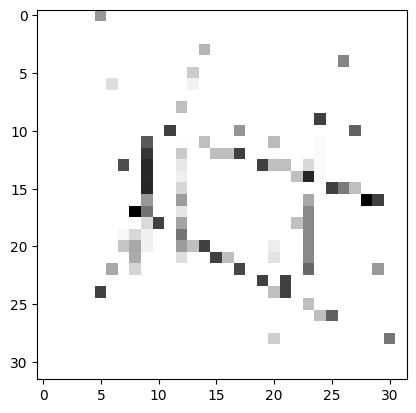

In [13]:
X = []
Y = []

for filename in os.listdir(folder_path):
    re_match = re.search(r"(\d+)(?=\.png)", filename)
    if not re_match:
        print(f"Could not read {filename}, skipping")
        continue

    digit = int(re_match.group(1))
    if digit != 0 or not is_colab_used:
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            # Resize the image to 32x32 pixels
            resized_image = cv2.resize(image, (32, 32))
            X.append(resized_image)
            Y.append(filename[digit - 1])
        else:
            print(f"Could not read {filename} from {file_path}, skipping")

print("len(X): ", len(X))
print("len(y): ", len(Y))
print("Sample image:")
rand_idx = np.random.randint(0, len(X))
plt.imshow(cv2.cvtColor(X[rand_idx], cv2.COLOR_BGR2RGB))

X = np.array(X)
Y = np.array(Y)

# Data Preprocessing


In [14]:
digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]
char_list = digits + letters


# Normalize
def normalize_data(data):
    return data / 255.0


# One hot encoding
def one_hot_encode_labels(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    encoded = label_encoder.transform(labels)
    categorical = to_categorical(encoded, num_classes=36)

    return categorical


def inverse_transform_labels(encoded_labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    return label_encoder.inverse_transform(encoded_labels)


X = normalize_data(X)
Y = one_hot_encode_labels(Y)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# Model


In [15]:
# Build Model Function
def build_model(learning_rate=0.01, dropout_rate=0.5):
    model = models.Sequential()
    model.add(
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32, 32, 1)
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(36, activation="softmax"))  # 0-9, a-z

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Train Model Function
def train_model(X, y):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    y_encoded = label_encoder.transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=36)

    model = build_model(input_shape=X.shape[1:])  # Using input shape from X
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(X, y_categorical, epochs=10, batch_size=32)

    return model, label_encoder


# Predict Function
def predict_model(model, label_encoder, X):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    return predicted_labels

# Cross Validation


In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_model()

    model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=64,
    )

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    kf_accuracy.append(val_acc)

print(f"Cross-Validation Accuracies: {kf_accuracy}")
print(f"Mean Accuracy: {np.mean(kf_accuracy)}")

Epoch 1/10


/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9333 - loss: 0.3550 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0227 - val_accuracy: 1.0000 - val_loss: 0.0120
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9975 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9995 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9989 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9998 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9998 - loss: 0.0068 - val_accuracy: 1.000

# Hyperparameter Tuning


In [17]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=build_model, verbose=0)

# Define the grid of hyperparameters
param_grid = {
    "model__learning_rate": [0.001, 0.01, 0.1],
    "model__dropout_rate": [0.0, 0.2, 0.5],
}

# Conduct the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_result.best_params_}")

/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.v

Best Hyperparameters: {'model__dropout_rate': 0.0, 'model__learning_rate': 0.001}


In [18]:
model = build_model(learning_rate=0.001, dropout_rate=0.5)